In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS, Predictive
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    detrend,
    ffnn_input_vector,
    load_thickness_time_series,
)
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import FFNN, compute_love_numbers, greens_function

print(PROJECT_ROOT)
pyro.set_rng_seed(42)

/mnt/c/Users/dnjllg/OneDrive - Danmarks Tekniske Universitet/Dokumenter/PhD/Courses/Model-based Machine Learning/premis


In [2]:
def compute_error(trues, predicted):
    """
    From course material
    """
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues) ** 2))
    return corr, mae, rae, rmse


def interval_outlier(
    df: pd.DataFrame,
    M_step=1,
    max_std=2,
    col_selected=["Thickness"],
):

    start = df.index[0]
    step1 = pd.Timestamp(start)
    step2 = pd.Timestamp(step1) + pd.DateOffset(months=M_step)

    endtime = df.index[-1]
    df2 = df.copy()

    while step1 < endtime:
        step2 = pd.Timestamp(step1) + pd.DateOffset(months=M_step)

        start_loc = step1.strftime("%Y-%m-%d")
        end_loc = step2.strftime("%Y-%m-%d")

        df_tmp = df2.loc[start_loc:end_loc, col_selected][0:-1]
        z = (df_tmp - df_tmp.mean()) / df_tmp.std()

        zfilter = abs(z) > max_std
        df.loc[start_loc:end_loc] = df[~zfilter]

        step1 = pd.Timestamp(step1) + pd.DateOffset(months=M_step)

    return df

In [3]:
df_em = default_em()

lmax = 512
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}
df = load_uplift(timefreq="W")
df_tmp = df.copy()
df_tmp = df_tmp.set_index("Time")
df.Thickness = (
    interval_outlier(df_tmp, M_step=24, max_std=2)
    .Thickness.interpolate()
    .fillna(method="bfill")
    .values
)

height = df.Thickness.values
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
y_train = detrend(up_kuaq)
df_em

/home/dnjllg/miniconda3/envs/MBML/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


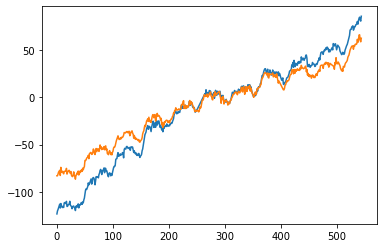

In [4]:
plt.plot(up_kuaq)
plt.plot(up_mik2)

<AxesSubplot:>

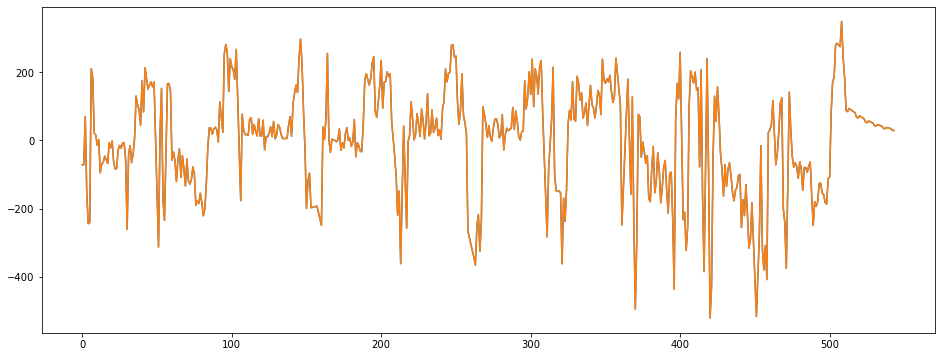

In [5]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, height)
df.Thickness.plot()

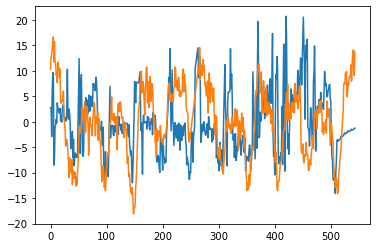

In [6]:
gf_test = -2e-4
tmp = height - np.mean(height)  # / np.std(height)
tmp2 = y_train
tmp2 = tmp2 - np.mean(tmp2)  # / np.std(tmp2)
plt.plot(2e2 * tmp * gf_test)
plt.plot(tmp2)

## For train test split, one hot encoded month numbers are included for later use in second model

In [8]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [9]:
standardized_height = height - np.mean(height)  # / np.std(height)
X_cat = np.concatenate([standardized_height[np.newaxis].T, month_number], axis=1)
X = torch.tensor(X_cat).float()

y1 = torch.tensor(detrend(up_kuaq)).float()
y1 = y1 - y1.mean()  # / y_train1.std()

y2 = torch.tensor(detrend(up_mik2)).float()
y2 = y2 - y2.mean()  # / y_train2.std()

y = torch.vstack([y1, y2]).T

In [10]:
train_perc = 0.80  # percentage of training data
split_point = int(train_perc * len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
# X_time_train = X_time[ix_train,:]
# X_time_test = X_time[ix_test,:]
X_train = X[ix_train, :]
X_test = X[ix_test, :]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 435
num test: 109


## load neural network to estimate love numbers

In [11]:
df_params, x = ffnn_input_vector(
    df_em, path="../data/processed/ffnn_variable_normalisation_params_512.csv"
)

ffnn = FFNN(31, 200, 513)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v2.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=513, bias=True)
  (relu): ReLU()
)

In [12]:
logmean = np.log10(5e10) / np.log10(np.exp(1))
logscale = np.log10(10) / np.log10(np.exp(1))
print(f"{logmean} {logscale}")
sigma_w = pyro.sample("tmp", dist.LogNormal(logmean * torch.ones(2000), 0.4))
# sigma_w = 1e11 * pyro.sample("tmp", dist.Exponential(torch.ones(2000)))
sigma_w.numpy()

24.635288842374557 2.302585092994046


array([8.0136135e+10, 2.9011651e+10, 3.0092407e+10, ..., 6.4752796e+10,
       3.7200859e+10, 5.4431408e+10], dtype=float32)

In [13]:
f"{sigma_w.numpy().min():e} {sigma_w.numpy().max():e}"

'1.217953e+10 2.083837e+11'

<AxesSubplot:ylabel='Density'>

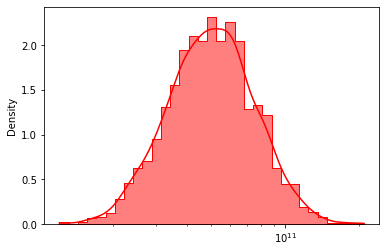

In [14]:
sns.histplot(
    # 1e11 + 1e10 * samples[node],
    sigma_w,
    kde=True,
    stat="density",
    element="step",
    color="red",
    log_scale=True,
)

In [15]:
def model(X, x, df_params, obs=None, df_em=None):
    N = len(X)
    t = torch.linspace(0, 1, N)

    sigma_w = pyro.sample("sigma", dist.HalfCauchy(1.2 * torch.ones(2)))

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.4 * torch.ones(1), 0.5))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )
    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))

    # Draw target
    with pyro.plate("data"):
        w = pyro.sample(
            "w", dist.Normal(gf * X[:, 0][..., None], sigma_w), obs=obs
        )  # 1e5 is a scaling constant

    return w

In [16]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
# mcmc.run(X_train, x, df_params, y_train, df_em)
mcmc.run(X_train, x, df_params, y_train, df_em)

Sample: 100%|████████████████████████████████████████| 1100/1100 [03:32,  5.17it/s, step size=3.72e-02, acc. prob=0.967]                  


In [183]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
rigidity_1[0] 36920078336.00 21297031168.00 31513962496.00 8908168192.00 67847143424.00    832.03      1.00
rigidity_2[0] 44320579584.00 21924009984.00 39411204096.00 13956470784.00 76775669760.00    964.92      1.00
     sigma[0]      6.81      0.24      6.80      6.39      7.19    249.15      1.00
     sigma[1]      5.66      0.19      5.66      5.37      6.00    319.04      1.00

Number of divergences: 0


In [17]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

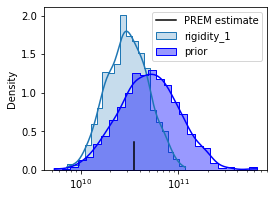

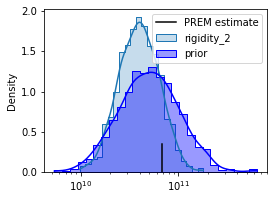

In [18]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.7)
)
for node in nodes:
    plt.figure(figsize=(4, 3))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.show()

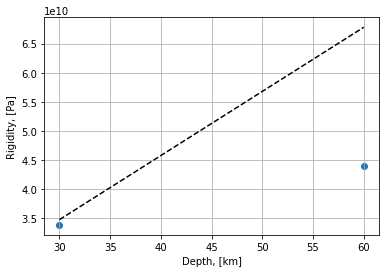

In [19]:
rigidity_list = []
prem_rigidity_list = []
for node in nodes:
    rigidity_list.append(samples[node].mean())
    prem_rigidity_list.append(prem_rigidity[node])

x_depth = [30, 60]
plt.scatter(x_depth, rigidity_list, label="Modelled rigidities")
plt.plot(
    x_depth, prem_rigidity_list, color="black", linestyle="--", label="PREM estimate"
)
plt.xlabel("Depth, [km]")
plt.ylabel("Rigidity, [Pa]")
plt.grid()

### Compare to observations

In [21]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (1000, 435, 2)
gf: (1000, 1, 2)


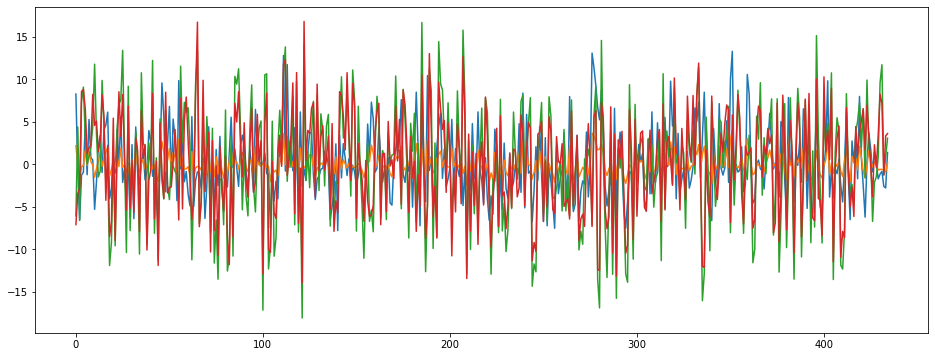

In [22]:
plt.figure(figsize=(16, 6))
plt.plot(predictive["w"].mean(axis=0))
plt.plot(y_train[:, 0])
plt.plot(y_train[:, 1])

In [23]:
predictive["gf"].mean(axis=0)

tensor([[-0.0264, -0.0075]])

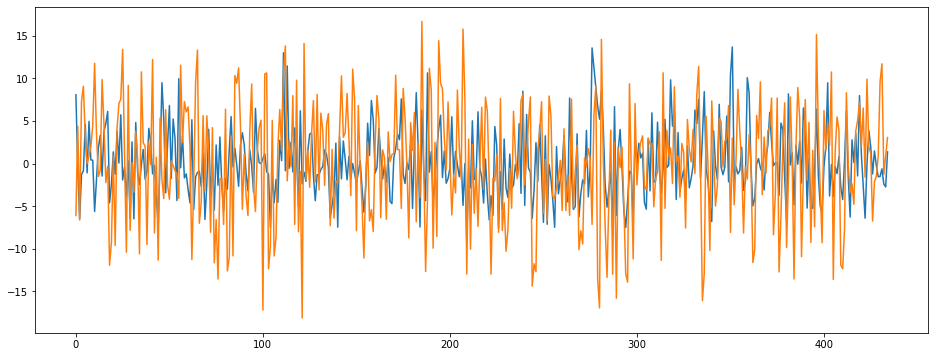

In [41]:
plt.figure(figsize=(16, 6))
plt.plot(predictive["gf"].mean(axis=0)[0, 0] * X_train[:,0])
plt.plot(y_train[:, 0])

In [ ]:
posterior_samples = mcmc.get_samples()

In [32]:
predictive["gf"].mean(axis=0).shape

torch.Size([1, 2])

In [36]:
y_hat = predictive["gf"].mean(axis=0) * X_test[:,0].reshape(109,1)

In [38]:
y_hat.shape

torch.Size([109, 2])

In [39]:
corr, mae, rae, rmse = compute_error(y_test.numpy(), y_hat.numpy())
print("CorrCoef: %.3f\nMAE: %.3f\nRAE: %.3f\nRMSE: %.3f" % (corr, mae, rae, rmse))

CorrCoef: -1.000
MAE: 4.880
RAE: 0.928
RMSE: 5.985


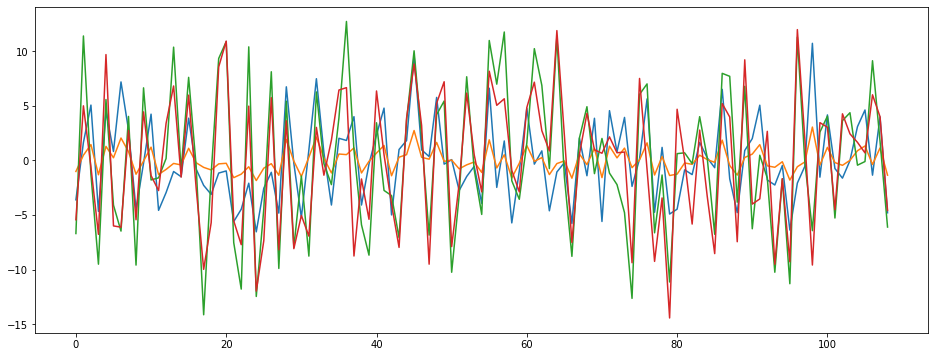

In [40]:
plt.figure(figsize=(16, 6))
plt.plot(y_hat)
plt.plot(y_test)

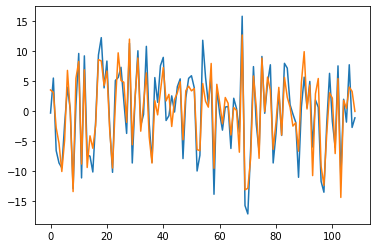

In [ ]:
plt.plot(y_test)

In [34]:
w_pred = (-gf_res * X_train[:, 0]).mean(axis=0)
plt.plot(y_train)
plt.plot(w_pred)
corr, mae, rae, rmse = compute_error(y_train.numpy(), w_pred.numpy())
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

NameError: name 'gf_res' is not defined